In [1]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import tensorflow as tf
import os
PATH_TO_CFG = "pipeline.config"
# PATH_TO_CKPT = "model/checkpoint"

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('model/ckpt-21').expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 3.2498295307159424 seconds


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings

import time
import cv2
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_LABELS = "label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

# warnings.filterwarnings('ignore')
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import collections
# Set headless-friendly backend.
import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements
import matplotlib.pyplot as plt  # pylint: disable=g-import-not-at-top
import numpy as np
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import six
from six.moves import range
from six.moves import zip
import tensorflow.compat.v1 as tf

from object_detection.core import keypoint_ops
from object_detection.core import standard_fields as fields
from object_detection.utils import shape_utils

_TITLE_LEFT_MARGIN = 10
_TITLE_TOP_MARGIN = 10
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]
def draw_box(
    image,
    boxes,
    classes,
    scores,
    category_index,
    instance_masks=None,
    instance_boundaries=None,
    keypoints=None,
    keypoint_scores=None,
    keypoint_edges=None,
    track_ids=None,
    use_normalized_coordinates=False,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    agnostic_mode=False,
    line_thickness=4,
    mask_alpha=.4,
    groundtruth_box_visualization_color='black',
    skip_boxes=False,
    skip_scores=False,
    skip_labels=False,
    skip_track_ids=False):

  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.
  box_to_display_str_map = collections.defaultdict(list)
  box_to_color_map = collections.defaultdict(str)
  box_to_instance_masks_map = {}
  box_to_instance_boundaries_map = {}
  box_to_keypoints_map = collections.defaultdict(list)
  box_to_keypoint_scores_map = collections.defaultdict(list)
  box_to_track_ids_map = {}
  if not max_boxes_to_draw:
    max_boxes_to_draw = boxes.shape[0]
  for i in range(boxes.shape[0]):
    if max_boxes_to_draw == len(box_to_color_map):
      break
    if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())
      if instance_masks is not None:
        box_to_instance_masks_map[box] = instance_masks[i]
      if instance_boundaries is not None:
        box_to_instance_boundaries_map[box] = instance_boundaries[i]
      if keypoints is not None:
        box_to_keypoints_map[box].extend(keypoints[i])
      if keypoint_scores is not None:
        box_to_keypoint_scores_map[box].extend(keypoint_scores[i])
      if track_ids is not None:
        box_to_track_ids_map[box] = track_ids[i]
      if scores is None:
        box_to_color_map[box] = groundtruth_box_visualization_color
      else:
        display_str = ''
        if not skip_labels:
          if not agnostic_mode:
            if classes[i] in six.viewkeys(category_index):
              class_name = category_index[classes[i]]['name']
            else:
              class_name = 'N/A'
            display_str = str(class_name)
        if not skip_scores:
          if not display_str:
            display_str = '{}%'.format(round(100*scores[i]))
          else:
            display_str = '{}: {}%'.format(display_str, round(100*scores[i]))
        if not skip_track_ids and track_ids is not None:
          if not display_str:
            display_str = 'ID {}'.format(track_ids[i])
          else:
            display_str = '{}: ID {}'.format(display_str, track_ids[i])
        box_to_display_str_map[box].append(display_str)
        if agnostic_mode:
          box_to_color_map[box] = 'DarkOrange'
        elif track_ids is not None:
          prime_multipler = _get_multiplier_for_color_randomness()
          box_to_color_map[box] = STANDARD_COLORS[
              (prime_multipler * track_ids[i]) % len(STANDARD_COLORS)]
        else:
          box_to_color_map[box] = STANDARD_COLORS[
              classes[i] % len(STANDARD_COLORS)]

  # Draw all boxes onto image.
  for box, color in box_to_color_map.items():
    
    ymin, xmin, ymax, xmax = box
    if instance_masks is not None:
      draw_mask_on_image_array(
          image,
          box_to_instance_masks_map[box],
          color=color,
          alpha=mask_alpha
      )
    if instance_boundaries is not None:
      draw_mask_on_image_array(
          image,
          box_to_instance_boundaries_map[box],
          color='red',
          alpha=1.0
      )
    BBB = draw_bounding_box_on_image_array(
        image,
        ymin,
        xmin,
        ymax,
        xmax,
        color=color,
        thickness=0 if skip_boxes else line_thickness,
        display_str_list=box_to_display_str_map[box],
        use_normalized_coordinates=use_normalized_coordinates)
    
    if keypoints is not None:
      
      keypoint_scores_for_box = None
      if box_to_keypoint_scores_map:
        keypoint_scores_for_box = box_to_keypoint_scores_map[box]
      AAA = draw_keypoints_on_image_array(
          image,
          box_to_keypoints_map[box],
          keypoint_scores_for_box,
          min_score_thresh=min_score_thresh,
          color=color,
          radius=line_thickness / 2,
          use_normalized_coordinates=use_normalized_coordinates,
          keypoint_edges=keypoint_edges,
          keypoint_edge_color=color,
          keypoint_edge_width=line_thickness // 2)
  try:
      return image, AAA, BBB
  except :
      return image, [], []

def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color='red',
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):

  image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
  BBB = draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                             thickness, display_str_list,
                             use_normalized_coordinates)
  np.copyto(image, np.array(image_pil))
  return BBB
  

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):

  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  if thickness > 0:
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)
  BBB = [int(left), int(top), int(right), int(bottom)]
  try:
    font = ImageFont.truetype('arial.ttf', 24)
  except IOError:
    font = ImageFont.load_default()

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                          text_bottom)],
        fill=color)
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin
  
  return BBB



def draw_keypoints_on_image_array(image,
                                  keypoints,
                                  keypoint_scores=None,
                                  min_score_thresh=0.5,
                                  color='red',
                                  radius=2,
                                  use_normalized_coordinates=True,
                                  keypoint_edges=None,
                                  keypoint_edge_color='green',
                                  keypoint_edge_width=2):

  image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
  AAA = draw_keypoints_on_image(image_pil,
                          keypoints,
                          keypoint_scores=keypoint_scores,
                          min_score_thresh=min_score_thresh,
                          color=color,
                          radius=radius,
                          use_normalized_coordinates=use_normalized_coordinates,
                          keypoint_edges=keypoint_edges,
                          keypoint_edge_color=keypoint_edge_color,
                          keypoint_edge_width=keypoint_edge_width)
  np.copyto(image, np.array(image_pil))
  return AAA


def draw_keypoints_on_image(image,
                            keypoints,
                            keypoint_scores=None,
                            min_score_thresh=0.5,
                            color='red',
                            radius=2,
                            use_normalized_coordinates=True,
                            keypoint_edges=None,
                            keypoint_edge_color='green',
                            keypoint_edge_width=2):

  AAA = []
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  keypoints = np.array(keypoints)
  keypoints_x = [k[1] for k in keypoints]
  keypoints_y = [k[0] for k in keypoints]
  if use_normalized_coordinates:
    keypoints_x = tuple([im_width * x for x in keypoints_x])
    keypoints_y = tuple([im_height * y for y in keypoints_y])
  if keypoint_scores is not None:
    keypoint_scores = np.array(keypoint_scores)
    valid_kpt = np.greater(keypoint_scores, min_score_thresh)
  else:
    valid_kpt = np.where(np.any(np.isnan(keypoints), axis=1),
                         np.zeros_like(keypoints[:, 0]),
                         np.ones_like(keypoints[:, 0]))
  valid_kpt = [v for v in valid_kpt]

  for keypoint_x, keypoint_y, valid in zip(keypoints_x, keypoints_y, valid_kpt):
    if valid:
      draw.ellipse([(keypoint_x - radius, keypoint_y - radius),
                    (keypoint_x + radius, keypoint_y + radius)],
                   outline=color, fill=color)
      AAA.append([int(keypoint_x), int(keypoint_y)])

  if keypoint_edges is not None:
    for keypoint_start, keypoint_end in keypoint_edges:
      if (keypoint_start < 0 or keypoint_start >= len(keypoints) or
          keypoint_end < 0 or keypoint_end >= len(keypoints)):
        continue
      if not (valid_kpt[keypoint_start] and valid_kpt[keypoint_end]):
        continue
      edge_coordinates = [
          keypoints_x[keypoint_start], keypoints_y[keypoint_start],
          keypoints_x[keypoint_end], keypoints_y[keypoint_end]
      ]
      draw.line(
          edge_coordinates, fill=keypoint_edge_color, width=keypoint_edge_width)
  return AAA

In [4]:
import math
def slope(x1, y1, x2, y2): # Line slope given two points:
    return (y2-y1)/(x2-x1)

def angle(s1, s2): 
    return math.degrees(math.atan((s2-s1)/(1+(s2*s1))))

def for_cal_angle(c0, c1, c2):
    lineA = ((AAA[c0][0], AAA[c0][1] ), (AAA[c1][0], AAA[c1][1] ))
    lineB = ((AAA[c1][0], AAA[c1][1] ), (AAA[c2][0], AAA[c2][1] ))

    slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
    slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])

    ang = angle(slope1, slope2)
    print('Angle in degrees = ', int(abs(ang)))

In [ ]:
# IMAGE_PATHS = [
#     'C:/Users/84916/Desktop/cat_goc/1.jpg',
#     'C:/Users/84916/Desktop/cat_goc/2.jpg',
#     'C:/Users/84916/Desktop/cat_goc/3.jpg',
#     'C:/Users/84916/Desktop/cat_goc/4.jpg',
#     'C:/Users/84916/Desktop/cat_goc/c1.jpeg',
#     'C:/Users/84916/Desktop/cat_goc/c2.jpeg',
#     'C:/Users/84916/Desktop/cat_goc/c3.jpeg',
#     'C:/Users/84916/Desktop/cat_goc/c4.jpeg',
#     'C:/Users/84916/Desktop/cat_goc/c5.jpeg',
#     'C:/Users/84916/Desktop/cat_goc/c6.jpeg',
# ]
# IMAGE_PATHS = ['C:/Users/84916/Desktop/cat_goc/3.jpg',]
IMAGE_PATHS = ['C:/Users/84916/Desktop/cat_goc/c6.jpeg',]

for i, img_path in enumerate(IMAGE_PATHS):
    img_np = load_image_into_numpy_array(img_path)
    input_tensor = tf.convert_to_tensor(np.expand_dims(img_np, 0),dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key:value[0, :num_detections].numpy() for key, value in detections.items()}
    detections["num_detections"] = num_detections
    detections["detection_classes"] = detections["detection_classes"].astype(np.int64)
    keypoints = None
    keypoint_scores = None

    if "detection_keypoints" in detections:
        keypoints = detections['detection_keypoints']
        keypoint_scores=detections['detection_keypoint_scores']
    label_id_offset = 1
    image_np_with_detections = img_np.copy()
    image_np_with_detections, AAA, BBB = draw_box(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            keypoints=keypoints,
            keypoint_edges=[[0, 1],[1, 2], [2, 3], [3, 0]],
            keypoint_scores=keypoint_scores,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=0.1,
            agnostic_mode=False,
#             skip_boxes=False,
            skip_boxes=True,
            skip_labels=True,
            skip_scores=True,
            skip_track_ids=True)
    


    print("AAA", AAA) #[[361.748623251915, 390.3252696990967], 
#                     # [39.32695023715496, 392.12050437927246], 
#                     # [33.55983607470989, 180.37547707557678], 
#                     # [369.11259055137634, 180.62534093856812]]

#     print("BBB", BBB) #[32.367591485381126, 176.74899101257324, 368.026682138443, 393.9006757736206]
#     print("-"*50)

#     polygon = Polygon(AAA)
#     s1 = polygon.area

#     start_point = (BBB[0], BBB[1])
#     end_point = (BBB[2], BBB[3])
#     width_rec = end_point[0] - start_point[0]
#     height_rec = end_point[1] - start_point[1]
#     s2 = width_rec * height_rec

#     print("OVERLAP:", s1/s2)
    cv2.imshow(str(i), cv2.resize(image_np_with_detections,(640, 640)))
    
    AAA_array = np.array(AAA)
    x_min = min(AAA_array[:,0])
    y_min = min(AAA_array[:,1])
    x_max = max(AAA_array[:,0])
    y_max = max(AAA_array[:,1])
    
    
#     for p in AAA:
#         cv2.circle(image_np_with_detections, p, 6, (0,255,255), 3)
    
#     cv2.rectangle(image_np_with_detections, (133, 369), (555, 779), (0,0,255), 3)
#     cv2.imshow("VVV", cv2.resize(image_np_with_detections,(640, 640)))

    for_cal_angle(0,1,2)
    for_cal_angle(1,2,3)
    for_cal_angle(2,3,0)
    for_cal_angle(3,0,1)
    
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
import time
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import cv2
import abc
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import six
import tensorflow.compat.v1 as tf
import math
import imutils

from six.moves import range
from six.moves import zip
from object_detection.core import keypoint_ops
from object_detection.core import standard_fields as fields
from object_detection.utils import shape_utils
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from PIL import Image
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_CFG = "pipeline.config"

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('model/ckpt-21').expect_partial()
PATH_TO_LABELS = "label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)
_TITLE_LEFT_MARGIN = 10
_TITLE_TOP_MARGIN = 10
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]


In [6]:
def slope(x1, y1, x2, y2): # Line slope given two points:
    return (y2-y1)/(x2-x1)


def angle(s1, s2):
    return math.degrees(math.atan((s2-s1)/(1+(s2*s1))))


def for_cal_angle(c0, c1, c2, AAA):
    lineA = ((AAA[c0][0], AAA[c0][1] ), (AAA[c1][0], AAA[c1][1] ))
    lineB = ((AAA[c1][0], AAA[c1][1] ), (AAA[c2][0], AAA[c2][1] ))

    slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
    slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])

    ang = angle(slope1, slope2)
    print('Angle in degrees = ', int(abs(ang)))


@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections


def load_image_into_numpy_array(path):
    return np.array(Image.open(path))


def draw_box(
        image,
        boxes,
        classes,
        scores,
        category_index,
        instance_masks=None,
        instance_boundaries=None,
        keypoints=None,
        keypoint_scores=None,
        keypoint_edges=None,
        track_ids=None,
        use_normalized_coordinates=False,
        max_boxes_to_draw=20,
        min_score_thresh=.5,
        agnostic_mode=False,
        line_thickness=4,
        mask_alpha=.4,
        groundtruth_box_visualization_color='black',
        skip_boxes=False,
        skip_scores=False,
        skip_labels=False,
        skip_track_ids=False):
    # Create a display string (and color) for every box location, group any boxes
    # that correspond to the same location.
    box_to_display_str_map = collections.defaultdict(list)
    box_to_color_map = collections.defaultdict(str)
    box_to_instance_masks_map = {}
    box_to_instance_boundaries_map = {}
    box_to_keypoints_map = collections.defaultdict(list)
    box_to_keypoint_scores_map = collections.defaultdict(list)
    box_to_track_ids_map = {}
    if not max_boxes_to_draw:
        max_boxes_to_draw = boxes.shape[0]
    for i in range(boxes.shape[0]):
        if max_boxes_to_draw == len(box_to_color_map):
            break
        if scores is None or scores[i] > min_score_thresh:
            box = tuple(boxes[i].tolist())
            if instance_masks is not None:
                box_to_instance_masks_map[box] = instance_masks[i]
            if instance_boundaries is not None:
                box_to_instance_boundaries_map[box] = instance_boundaries[i]
            if keypoints is not None:
                box_to_keypoints_map[box].extend(keypoints[i])
            if keypoint_scores is not None:
                box_to_keypoint_scores_map[box].extend(keypoint_scores[i])
            if track_ids is not None:
                box_to_track_ids_map[box] = track_ids[i]
            if scores is None:
                box_to_color_map[box] = groundtruth_box_visualization_color
            else:
                display_str = ''
                if not skip_labels:
                    if not agnostic_mode:
                        if classes[i] in six.viewkeys(category_index):
                            class_name = category_index[classes[i]]['name']
                        else:
                            class_name = 'N/A'
                        display_str = str(class_name)
                if not skip_scores:
                    if not display_str:
                        display_str = '{}%'.format(round(100 * scores[i]))
                    else:
                        display_str = '{}: {}%'.format(display_str, round(100 * scores[i]))
                if not skip_track_ids and track_ids is not None:
                    if not display_str:
                        display_str = 'ID {}'.format(track_ids[i])
                    else:
                        display_str = '{}: ID {}'.format(display_str, track_ids[i])
                box_to_display_str_map[box].append(display_str)
                if agnostic_mode:
                    box_to_color_map[box] = 'DarkOrange'
                elif track_ids is not None:
                    prime_multipler = _get_multiplier_for_color_randomness()
                    box_to_color_map[box] = STANDARD_COLORS[
                        (prime_multipler * track_ids[i]) % len(STANDARD_COLORS)]
                else:
                    box_to_color_map[box] = STANDARD_COLORS[
                        classes[i] % len(STANDARD_COLORS)]

    # Draw all boxes onto image.
    for box, color in box_to_color_map.items():

        ymin, xmin, ymax, xmax = box
        if instance_masks is not None:
            draw_mask_on_image_array(
                image,
                box_to_instance_masks_map[box],
                color=color,
                alpha=mask_alpha
            )
        if instance_boundaries is not None:
            draw_mask_on_image_array(
                image,
                box_to_instance_boundaries_map[box],
                color='red',
                alpha=1.0
            )
        BBB = draw_bounding_box_on_image_array(
            image,
            ymin,
            xmin,
            ymax,
            xmax,
            color=color,
            thickness=0 if skip_boxes else line_thickness,
            display_str_list=box_to_display_str_map[box],
            use_normalized_coordinates=use_normalized_coordinates)

        if keypoints is not None:

            keypoint_scores_for_box = None
            if box_to_keypoint_scores_map:
                keypoint_scores_for_box = box_to_keypoint_scores_map[box]
            AAA = draw_keypoints_on_image_array(
                image,
                box_to_keypoints_map[box],
                keypoint_scores_for_box,
                min_score_thresh=min_score_thresh,
                color=color,
                radius=line_thickness / 2,
                use_normalized_coordinates=use_normalized_coordinates,
                keypoint_edges=keypoint_edges,
                keypoint_edge_color=color,
                keypoint_edge_width=line_thickness // 2)
    try:
        return image, AAA, BBB
    except:
        return image, [], []


def draw_bounding_box_on_image_array(image,
                                     ymin,
                                     xmin,
                                     ymax,
                                     xmax,
                                     color='red',
                                     thickness=4,
                                     display_str_list=(),
                                     use_normalized_coordinates=True):
    image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
    BBB = draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                                     thickness, display_str_list,
                                     use_normalized_coordinates)
    np.copyto(image, np.array(image_pil))
    return BBB


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=True):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                      ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    if thickness > 0:
        draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
                   (left, top)],
                  width=thickness,
                  fill=color)
    BBB = [int(left), int(top), int(right), int(bottom)]
    try:
        font = ImageFont.truetype('arial.ttf', 24)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle(
            [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                              text_bottom)],
            fill=color)
        draw.text(
            (left + margin, text_bottom - text_height - margin),
            display_str,
            fill='black',
            font=font)
        text_bottom -= text_height - 2 * margin

    return BBB


def draw_keypoints_on_image_array(image,
                                  keypoints,
                                  keypoint_scores=None,
                                  min_score_thresh=0.5,
                                  color='red',
                                  radius=2,
                                  use_normalized_coordinates=True,
                                  keypoint_edges=None,
                                  keypoint_edge_color='green',
                                  keypoint_edge_width=2):
    image_pil = Image.fromarray(np.uint8(image)).convert('RGB')
    AAA = draw_keypoints_on_image(image_pil,
                                  keypoints,
                                  keypoint_scores=keypoint_scores,
                                  min_score_thresh=min_score_thresh,
                                  color=color,
                                  radius=radius,
                                  use_normalized_coordinates=use_normalized_coordinates,
                                  keypoint_edges=keypoint_edges,
                                  keypoint_edge_color=keypoint_edge_color,
                                  keypoint_edge_width=keypoint_edge_width)
    np.copyto(image, np.array(image_pil))
    return AAA


def draw_keypoints_on_image(image,
                            keypoints,
                            keypoint_scores=None,
                            min_score_thresh=0.5,
                            color='red',
                            radius=2,
                            use_normalized_coordinates=True,
                            keypoint_edges=None,
                            keypoint_edge_color='green',
                            keypoint_edge_width=2):
    AAA = []
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    keypoints = np.array(keypoints)
    keypoints_x = [k[1] for k in keypoints]
    keypoints_y = [k[0] for k in keypoints]
    if use_normalized_coordinates:
        keypoints_x = tuple([im_width * x for x in keypoints_x])
        keypoints_y = tuple([im_height * y for y in keypoints_y])
    if keypoint_scores is not None:
        keypoint_scores = np.array(keypoint_scores)
        valid_kpt = np.greater(keypoint_scores, min_score_thresh)
    else:
        valid_kpt = np.where(np.any(np.isnan(keypoints), axis=1),
                             np.zeros_like(keypoints[:, 0]),
                             np.ones_like(keypoints[:, 0]))
    valid_kpt = [v for v in valid_kpt]

    for keypoint_x, keypoint_y, valid in zip(keypoints_x, keypoints_y, valid_kpt):
        if valid:
#             draw.ellipse([(keypoint_x - radius, keypoint_y - radius),
#                           (keypoint_x + radius, keypoint_y + radius)],
#                          outline=color, fill=color)
            AAA.append([int(keypoint_x), int(keypoint_y)])

    if keypoint_edges is not None:
        for keypoint_start, keypoint_end in keypoint_edges:
            if (keypoint_start < 0 or keypoint_start >= len(keypoints) or
                    keypoint_end < 0 or keypoint_end >= len(keypoints)):
                continue
            if not (valid_kpt[keypoint_start] and valid_kpt[keypoint_end]):
                continue
            edge_coordinates = [
                keypoints_x[keypoint_start], keypoints_y[keypoint_start],
                keypoints_x[keypoint_end], keypoints_y[keypoint_end]
            ]
            draw.line(
                edge_coordinates, fill=keypoint_edge_color, width=keypoint_edge_width)
    return AAA


In [3]:
# IMAGE_PATHS = ['C:/Users/84916/Desktop/cat_goc/c3.jpeg', ]
IMAGE_PATHS = ['C:/Users/84916/Desktop/cat_goc/p1.jpg', ]

for i, img_path in enumerate(IMAGE_PATHS):
    img_np = load_image_into_numpy_array(img_path)
    input_tensor = tf.convert_to_tensor(np.expand_dims(img_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections["num_detections"] = num_detections
    detections["detection_classes"] = detections["detection_classes"].astype(np.int64)
    keypoints = None
    keypoint_scores = None

    if "detection_keypoints" in detections:
        keypoints = detections['detection_keypoints']
        keypoint_scores = detections['detection_keypoint_scores']
    label_id_offset = 1
    image_np_with_detections = img_np.copy()
    image_np_with_detections, AAA, BBB = draw_box(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        keypoints=keypoints,
#         keypoint_edges=[[0, 1], [1, 2], [2, 3], [3, 0]],
        keypoint_scores=keypoint_scores,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=0.1,
        agnostic_mode=False,
        # skip_boxes=False,
        skip_boxes=True,
        skip_labels=True,
        skip_scores=True,
        skip_track_ids=True)

    print("AAA", AAA)  # [[361.748623251915, 390.3252696990967],
    #                     # [39.32695023715496, 392.12050437927246],
    #                     # [33.55983607470989, 180.37547707557678],
    #                     # [369.11259055137634, 180.62534093856812]]
    for_cal_angle(0, 1, 2, AAA)
    for_cal_angle(1, 2, 3, AAA)
    for_cal_angle(2, 3, 0, AAA)
    for_cal_angle(3, 0, 1, AAA)
    
    pts1 = np.float32(AAA)
    pts2 = np.float32([[0, 0], [640, 0], [640, 480], [0, 480]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(image_np_with_detections, matrix, (640, 480))
    
#     cv2.imshow(str(i), cv2.resize(image_np_with_detections, (640, 640)))
    cv2.imshow(str(i)+"_"+str(i), cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    bbox = cv2.cvtColor(image_np_with_detections[BBB[1]:BBB[3], BBB[0]:BBB[2]], cv2.COLOR_BGR2RGB)
    cv2.imshow("box", bbox)

cv2.waitKey(0)
cv2.destroyAllWindows()

Instructions for updating:
Use `tf.cast` instead.
AAA [[413, 440], [430, 726], [226, 739], [245, 446]]
Angle in degrees =  89
Angle in degrees =  82
Angle in degrees =  84
Angle in degrees =  88


In [9]:
#check anh photo
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')
# IMAGE_PATHS = ['C:/Users/84916/Desktop/cat_goc/1.jpg',
#                'C:/Users/84916/Desktop/cat_goc/2.jpg',
#                'C:/Users/84916/Desktop/cat_goc/3.jpg',
#                'C:/Users/84916/Desktop/cat_goc/4.jpg',
#                'C:/Users/84916/Desktop/cat_goc/c1.jpeg',
#                'C:/Users/84916/Desktop/cat_goc/c2.jpeg',
#                'C:/Users/84916/Desktop/cat_goc/c3.jpeg',
#                'C:/Users/84916/Desktop/cat_goc/c4.jpeg',
#                'C:/Users/84916/Desktop/cat_goc/c5.jpeg',
#                'C:/Users/84916/Desktop/cat_goc/c6.jpeg',
#                'C:/Users/84916/Desktop/cat_goc/p1.jpg',
#                'C:/Users/84916/Desktop/cat_goc/p2.jpg',
#                'C:/Users/84916/Desktop/cat_goc/p3.jpg',
#                'C:/Users/84916/Desktop/cat_goc/p4.jpg',
#                'C:/Users/84916/Desktop/cat_goc/p5.jpg',
#               ]
              
IMAGE_PATHS = ['C:/Users/84916/Desktop/cat_goc/p2.jpg']
# IMAGE_PATHS = ['C:/Users/84916/Desktop/cat_goc/c5.jpeg', ]

for i, img_path in enumerate(IMAGE_PATHS):
    img_np = load_image_into_numpy_array(img_path)
    input_tensor = tf.convert_to_tensor(np.expand_dims(img_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections["num_detections"] = num_detections
    detections["detection_classes"] = detections["detection_classes"].astype(np.int64)
    keypoints = None
    keypoint_scores = None

    if "detection_keypoints" in detections:
        keypoints = detections['detection_keypoints']
        keypoint_scores = detections['detection_keypoint_scores']
    label_id_offset = 1
    image_np_with_detections = img_np.copy()
    image_np_with_detections, AAA, BBB = draw_box(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes'] + label_id_offset,
        detections['detection_scores'],
        category_index,
        keypoints=keypoints,
        keypoint_edges=[[0, 1], [1, 2], [2, 3], [3, 0]],
        keypoint_scores=keypoint_scores,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=0.1,
        agnostic_mode=False,
        # skip_boxes=False,
        skip_boxes=True,
        skip_labels=True,
        skip_scores=True,
        skip_track_ids=True)

    bbox = cv2.cvtColor(image_np_with_detections[BBB[1]:BBB[3], BBB[0]:BBB[2]], cv2.COLOR_BGR2RGB)
    bbox_hsv = cv2.cvtColor(bbox, cv2.COLOR_BGR2HSV)
    bbox_hsv_saturation = bbox_hsv[:,:,1]
    
    histr1 = cv2.calcHist([bbox_hsv_saturation],[0],None,[256],[0,256])
    print(histr1.shape)
    # show the plotting graph of an image
    
#     plt.plot(histr1)
    
    print(i, AAA)
    
    cv2.imshow(str(i), bbox)
    cv2.imshow(str(i)+"_HSV", bbox_hsv_saturation)
#     plt.show()
    
cv2.waitKey(0)
cv2.destroyAllWindows()

(256, 1)
0 []


In [267]:
bbox_hsv_saturation.shape

(284, 176)

[0.95613605]


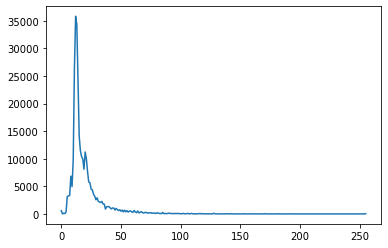

In [18]:
import cv2
  
# importing library for plotting
from matplotlib import pyplot as plt
path_img = 'D:/Code/Tima_Onbroading/Tima_API/result.jpg'
# path_img = 'C:/Users/84916/Desktop/cat_goc/c5.jpeg'
# reads an input image
img = cv2.imread(path_img)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hsv_sat = hsv[:, :, 1]
  
# find frequency of pixels in range 0-255
histr = cv2.calcHist([hsv_sat],[0],None,[256],[0,256])
print(sum(histr[0:50]) / sum(histr[0:]))
# show the plotting graph of an image
plt.plot(histr)
plt.show()
cv2.imshow("aaaa", hsv_sat)
cv2.waitKey(0)
cv2.destroyAllWindows()